In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
#%matplotlib inline
import sys
sys.path.append('../')
from package_global_functions import *

def getTimeEvosPath():
    extSSDpath = getExternalSSDpath()
    if os.path.exists(extSSDpath):
        path = extSSDpath + getProjectFoldername() + '/evo_to_stationary/time_evos_dif_cond'
    else:
        path = '/time_evos_dif_cond'
    return path

In [2]:
from scipy.ndimage import gaussian_filter1d

def search_time(w,t,evo,sig=0):
    """
    sig=0 -> no gaussian filter; sig != 0 -> apply gaussian filter with this sigma
    """
    if sig:
        evo_mod = gaussian_filter1d(evo, sig)
    else:
        evo_mod = evo
    time = float('nan')
    for i in range(len(evo_mod)-w):
        block_avg = np.average(evo_mod[i:i+w])
        if abs(evo_mod[i+w+1] - block_avg) < t:
            time = i+w+1
            break
    return time

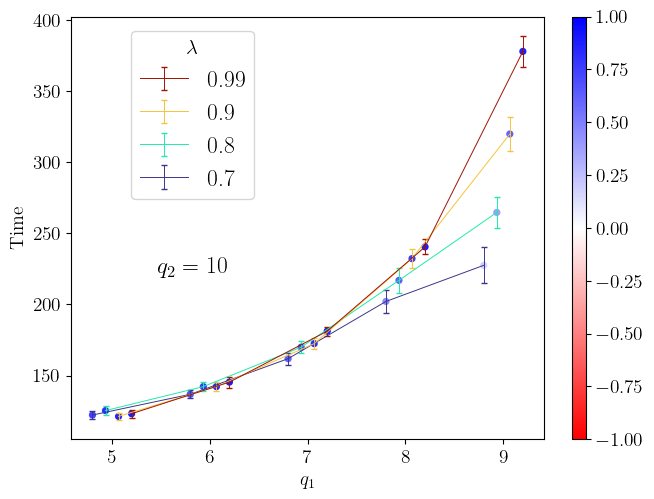

In [13]:
# varying q1 for a set of lambdas:
latexFont(titlesize=14, ticklabelssize=14, labelsize=14)

N, pi1, pi2, q2 = 5000, 0.1, 0.1, 10
q1s = [1,2,3,4,5,6,7,8,9]
q1s = [5,6,7,8,9]

lambs = [0.7, 0.8, 0.9, 0.99]
colors = plt.cm.cool(np.linspace(0,1,len(lambs)))
colors = plt.cm.turbo(np.linspace(0.05,0.95,len(lambs)))
jitterer_ls_q1 = np.linspace(-0.2,0.2, len(lambs))
fig, ax = plt.subplots()

for l,c,jitterer in zip(lambs,colors,jitterer_ls_q1):
    times_q1, times_q1_sigma, Qs_q1 = [], [], []
    for q1 in q1s:
        # get the dataframes with the time evolutions:
        folder = f'time_evo_csv_N_{N}_pi1_{pi1}_pi2_{pi2}_q1_{q1}_q2_{q2}_l_{l}'
        files = glob.glob(f'{getTimeEvosPath()}/{folder}/*')
        dfs = [pd.read_csv(file) for file in files]
        times, Qs = [], []
        for df in dfs:
            # time = search_time(w=10, t=0.0005, evo=df['f2'], sig=20)
            time = search_time(w=75, t=0.0005, evo=df['f2'])
            times.append(time)
            # check value of consensus:
            df['Q'] = df['f2'] - 2*df['f1']
            Q = np.average(df['Q'].iloc[time:])
            Qs.append(Q)
        times_q1.append(np.average(times)), times_q1_sigma.append(np.std(times)/np.sqrt(len(dfs))), Qs_q1.append(np.average(Qs))
    # Consenus markers:
    Q_markers = ['*' if Q>0 else '.' for Q in Qs_q1]
    times_Q_pos = [time for time,Q in zip(times_q1,Qs_q1) if Q>0]
    q1s_pos = [q1 for q1,Q in zip(q1s, Qs_q1) if Q>0]
    times_Q_neg = [time for time,Q in zip(times_q1,Qs_q1) if Q<0]
    q1s_neg = [q1 for q1,Q in zip(q1s, Qs_q1) if Q<0]
    ax.errorbar(q1s+jitterer, times_q1, times_q1_sigma, capsize=2.0, elinewidth=0.7, lw=0.7, marker=None, color=c, label=f'{l}')
    # ax.scatter(q1s_pos, times_Q_pos, marker='*')
    # ax.scatter(q1s_neg, times_Q_neg, marker='.')
    points = ax.scatter(q1s+jitterer, times_q1, c=Qs_q1, cmap='bwr_r', vmin=-1, vmax=1, marker='.', s=70)

cb = fig.colorbar(points, aspect=30, fraction=0.10)

ax.set(xlabel='$q_1$', ylabel='Time')
fig.text(0.23, 0.45, f'$q_2 = {q2}$', fontsize=17)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], title='$\lambda$', fontsize=17, loc=(0.2, 0.6))
fig.tight_layout(pad=0.02)
fig.savefig(f'stat_times_q1_many_l_70_to_99_pi1_{pi1}_pi2_{pi2}_q2_{q2}_N_{N}.tiff')

### Figure for the paper: